In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
import re
import time
import os
from picconfig import iconpath, phecatpath, datpath, imgpath, showcasepath, imppath, survimppath, temppath

In [3]:
impdict = {}
import os
for i in tqdm(os.listdir(imppath)):
    try:
        temp=np.load(imppath+i,allow_pickle=True)
    except:
        print(i)
        continue
    num = i.split('s')[0]
    impdict[int(num)]=temp/np.linalg.norm(temp,ord=1)
gs=[]
for i in range(1560):
    gs.append(impdict[i])
impdict=np.array(gs)

impdictds = {}
for i in tqdm(os.listdir(survimppath)):
    try:
        temp=np.load(survimppath+i,allow_pickle=True)
    except:
        print(i)
        continue
    num = i.split('s')[0]
    impdictds[int(num)]=temp/np.linalg.norm(temp,ord=1)
gs=[]
for i in range(1560):
    gs.append(impdictds[i])
impdictds=np.array(gs)

100%|██████████| 1560/1560 [00:00<00:00, 28060.48it/s]


In [4]:
impdict = impdict[:, 0:-1]
impdictds = impdictds[:, 0:-1]

In [5]:
cats='''Intestine,Digestive
Genital,Reproductive
Oral,Sensory
Upper digestive,Digestive
Digestive gland,Digestive
Bone and soft tissues,Tissues
Skin,Sensory
Urinary,Urinary
Eye,Sensory
CNS,Nervous
Endocrine,Endocrine
Blood,Circulatory
Vessel,Circulatory
Mental,Nervous
PNS,Nervous
Ear,Sensory
Heart,Circulatory
Upper respiratory,Respiratory
Lung,Respiratory
Pregnancy,Reproductive
Microbe,Externalities'''.split('\n')
catsd={}
for i in cats:
    if i.split(',')[1] in catsd.keys():
        catsd[i.split(',')[1]]+=[i.split(',')[0]]
    else:
        catsd[i.split(',')[1]]=[i.split(',')[0]]
phecat=np.load(phecatpath,allow_pickle=1)[0]
finalcat={}
for k,v in catsd.items():
    temp=[]
    for i in v:
        temp+=list(phecat[i])
    finalcat[k]=np.array(temp)
catnames=list(finalcat.keys())

In [6]:
filelist = [
f"{datpath}/baseline_imputed.csv",
f"{datpath}/lifestyle_imputed.csv",
f"{datpath}/measurement_imputed.csv",
f"{datpath}/environment_imputed.csv",
f"{datpath}/genetic_imputed.csv"]
coldata = []
coldata_raw=[]
indexes = [0,1,2,3,4]
for i in indexes:
    f = pd.read_csv(filelist[int(i)])
    coldata_raw+=list(f.columns)[1:]
    coldata+=list(f.columns)[1:]
f = pd.read_csv(imgpath)
coldata_raw+=list(f.columns)
coldata+=list(f.columns)

In [7]:
fieldid = []
for col in coldata:
    if col.startswith('PRSPC'):
        fieldid.append('PRSPC')
    elif col.startswith('Heart_PC'):
        fieldid.append('Heart MRI')
    elif col.startswith('Ultrasound_PC'):
        fieldid.append('Ultrasound')
    elif col.startswith('Brain_PC'):
        fieldid.append('Brain MRI')
    elif col=="PC_indicator":
        pass
    else:
        fieldid.append(re.split('[-|#]', col)[0])
fieldid = np.array(fieldid)

In [8]:
df=pd.read_csv(showcasepath)

In [9]:
Class_top = ['Baseline characteristics', 'Life', 'Measures', 'Natural and social environment', 'Genetic']
fielddict = {}
for c in Class_top:
    fielddict[c] = {}
    subdf = df[df['Class_top']==c]
    for name in np.unique(subdf['Imp_name'].to_numpy()):
        fielddict[c][name] = subdf.loc[subdf['Imp_name']==name,'FieldID'].to_numpy().astype(str)
fielddict['Genetic']['Genetic PRS'] = np.array(['PRSPC'])
fielddict['Image'] = {
    'Brain MRI': np.array(['Brain MRI']),
    'Carotid ultrasound': np.array(['Ultrasound']),
    'Heart MRI': np.array(['Heart MRI']),
}

In [10]:
indexdict = {}
for c, v in fielddict.items():
    indexdict[c] = {}
    for name, ind in v.items():
        indexdict[c][name] = np.where(np.in1d(fieldid,fielddict[c][name]))[0]

In [11]:
importancedict = {}
for c, v in indexdict.items():
    importancedict[c] = {}
    for name, ind in v.items():
        temp = impdict[:, ind]
        max_abs_values = np.amax(np.abs(temp), axis=1)
        result = temp[np.arange(len(temp)), np.argmax(np.abs(temp), axis=1)]
        importancedict[c][name] = result
importancedictds = {}
for c, v in indexdict.items():
    importancedictds[c] = {}
    for name, ind in v.items():
        temp = impdictds[:, ind]
        max_abs_values = np.amax(np.abs(temp), axis=1)
        result = temp[np.arange(len(temp)), np.argmax(np.abs(temp), axis=1)]
        importancedictds[c][name] = result

In [12]:
fieldnames = []
imp = []
for c, v in importancedict.items():
    for name, ind in v.items():
        fieldnames.append(name)
        imp.append(ind)
fieldnames = np.array(fieldnames)
imp = np.vstack(imp)

impds = []
for c, v in importancedictds.items():
    for name, ind in v.items():
        impds.append(ind)
impds = np.vstack(impds)

In [13]:
gscat={}
for k,v in finalcat.items():
    temp=[]
    for i in v:
        temp.append(imp[:,i])
    gscat[k]=np.mean(np.abs(temp),axis=0)
summary = np.vstack(list(gscat.values()))
impsum = np.sum(np.abs(imp), axis=1)
k = 10
focusidx = np.argsort(impsum)[-k:][::-1]

gscatds={}
for k,v in finalcat.items():
    temp=[]
    for i in v:
        temp.append(impds[:,i])
    gscatds[k]=np.mean(np.abs(temp),axis=0)
summaryds = np.vstack(list(gscatds.values()))
impdssum = np.sum(np.abs(impds), axis=1)
kds = 10
focusidxds = np.argsort(impdssum)[-kds:][::-1]

In [14]:
gscat={}
for k,v in finalcat.items():
    temp=[]
    for i in v:
        temp.append(imp[focusidx, i])
    gscat[k]=np.mean(np.abs(temp),axis=0)

gscatds={}
for k,v in finalcat.items():
    temp=[]
    for i in v:
        temp.append(impds[focusidxds, i])
    gscatds[k]=np.mean(np.abs(temp),axis=0)

In [15]:
linewidth=[]
for i in finalcat.keys():
    linewidth.append(gscat[i])
linewidth=np.array(linewidth)
coln=[]
for i in focusidx:
    coln.append(fieldnames[i])

linewidthds=[]
for i in finalcat.keys():
    linewidthds.append(gscatds[i])
linewidthds=np.array(linewidthds)
colnds=[]
for i in focusidxds:
    colnds.append(fieldnames[i])

In [16]:
lwdf=pd.DataFrame(np.array(linewidth).T,index=coln,columns=finalcat.keys())
shuffled_df  = lwdf
drawdata=shuffled_df.to_numpy()

lwdfds=pd.DataFrame(np.array(linewidthds).T,index=colnds,columns=finalcat.keys())
shuffled_dfds  = lwdfds
drawdatads=shuffled_dfds.to_numpy()

In [17]:
colors = ['#403990','#80A6E2','#FBDD85','#F46F43','#CF3D3E']
cm = LinearSegmentedColormap.from_list('Nature', colors, N=10)

In [18]:
def auto_wrap(text, max_length):
    words = text.split()
    lines = []
    current_line = ""
    
    for word in words:
        if len(current_line + word) <= max_length:
            current_line += word + " " 
        else:
            lines.append(current_line.strip()) 
            current_line = word + " "  
        
    lines.append(current_line.strip()) 
    
    return "\n".join(lines)

In [19]:
def std_polynomial_curve(x):
    x_val = 0
    y_val = 1
    return (2*x_val - 2*y_val)*x**3 + (-3*x_val + 3*y_val)*x**2 + x_val

xstd = np.linspace(0, 1, 1000)
ystd = std_polynomial_curve(xstd)
def curve(x1,y1,x2,y2):
    yout=ystd*(y2-y1)+y1
    xout=xstd*(x2-x1)+x1
    return xout,yout

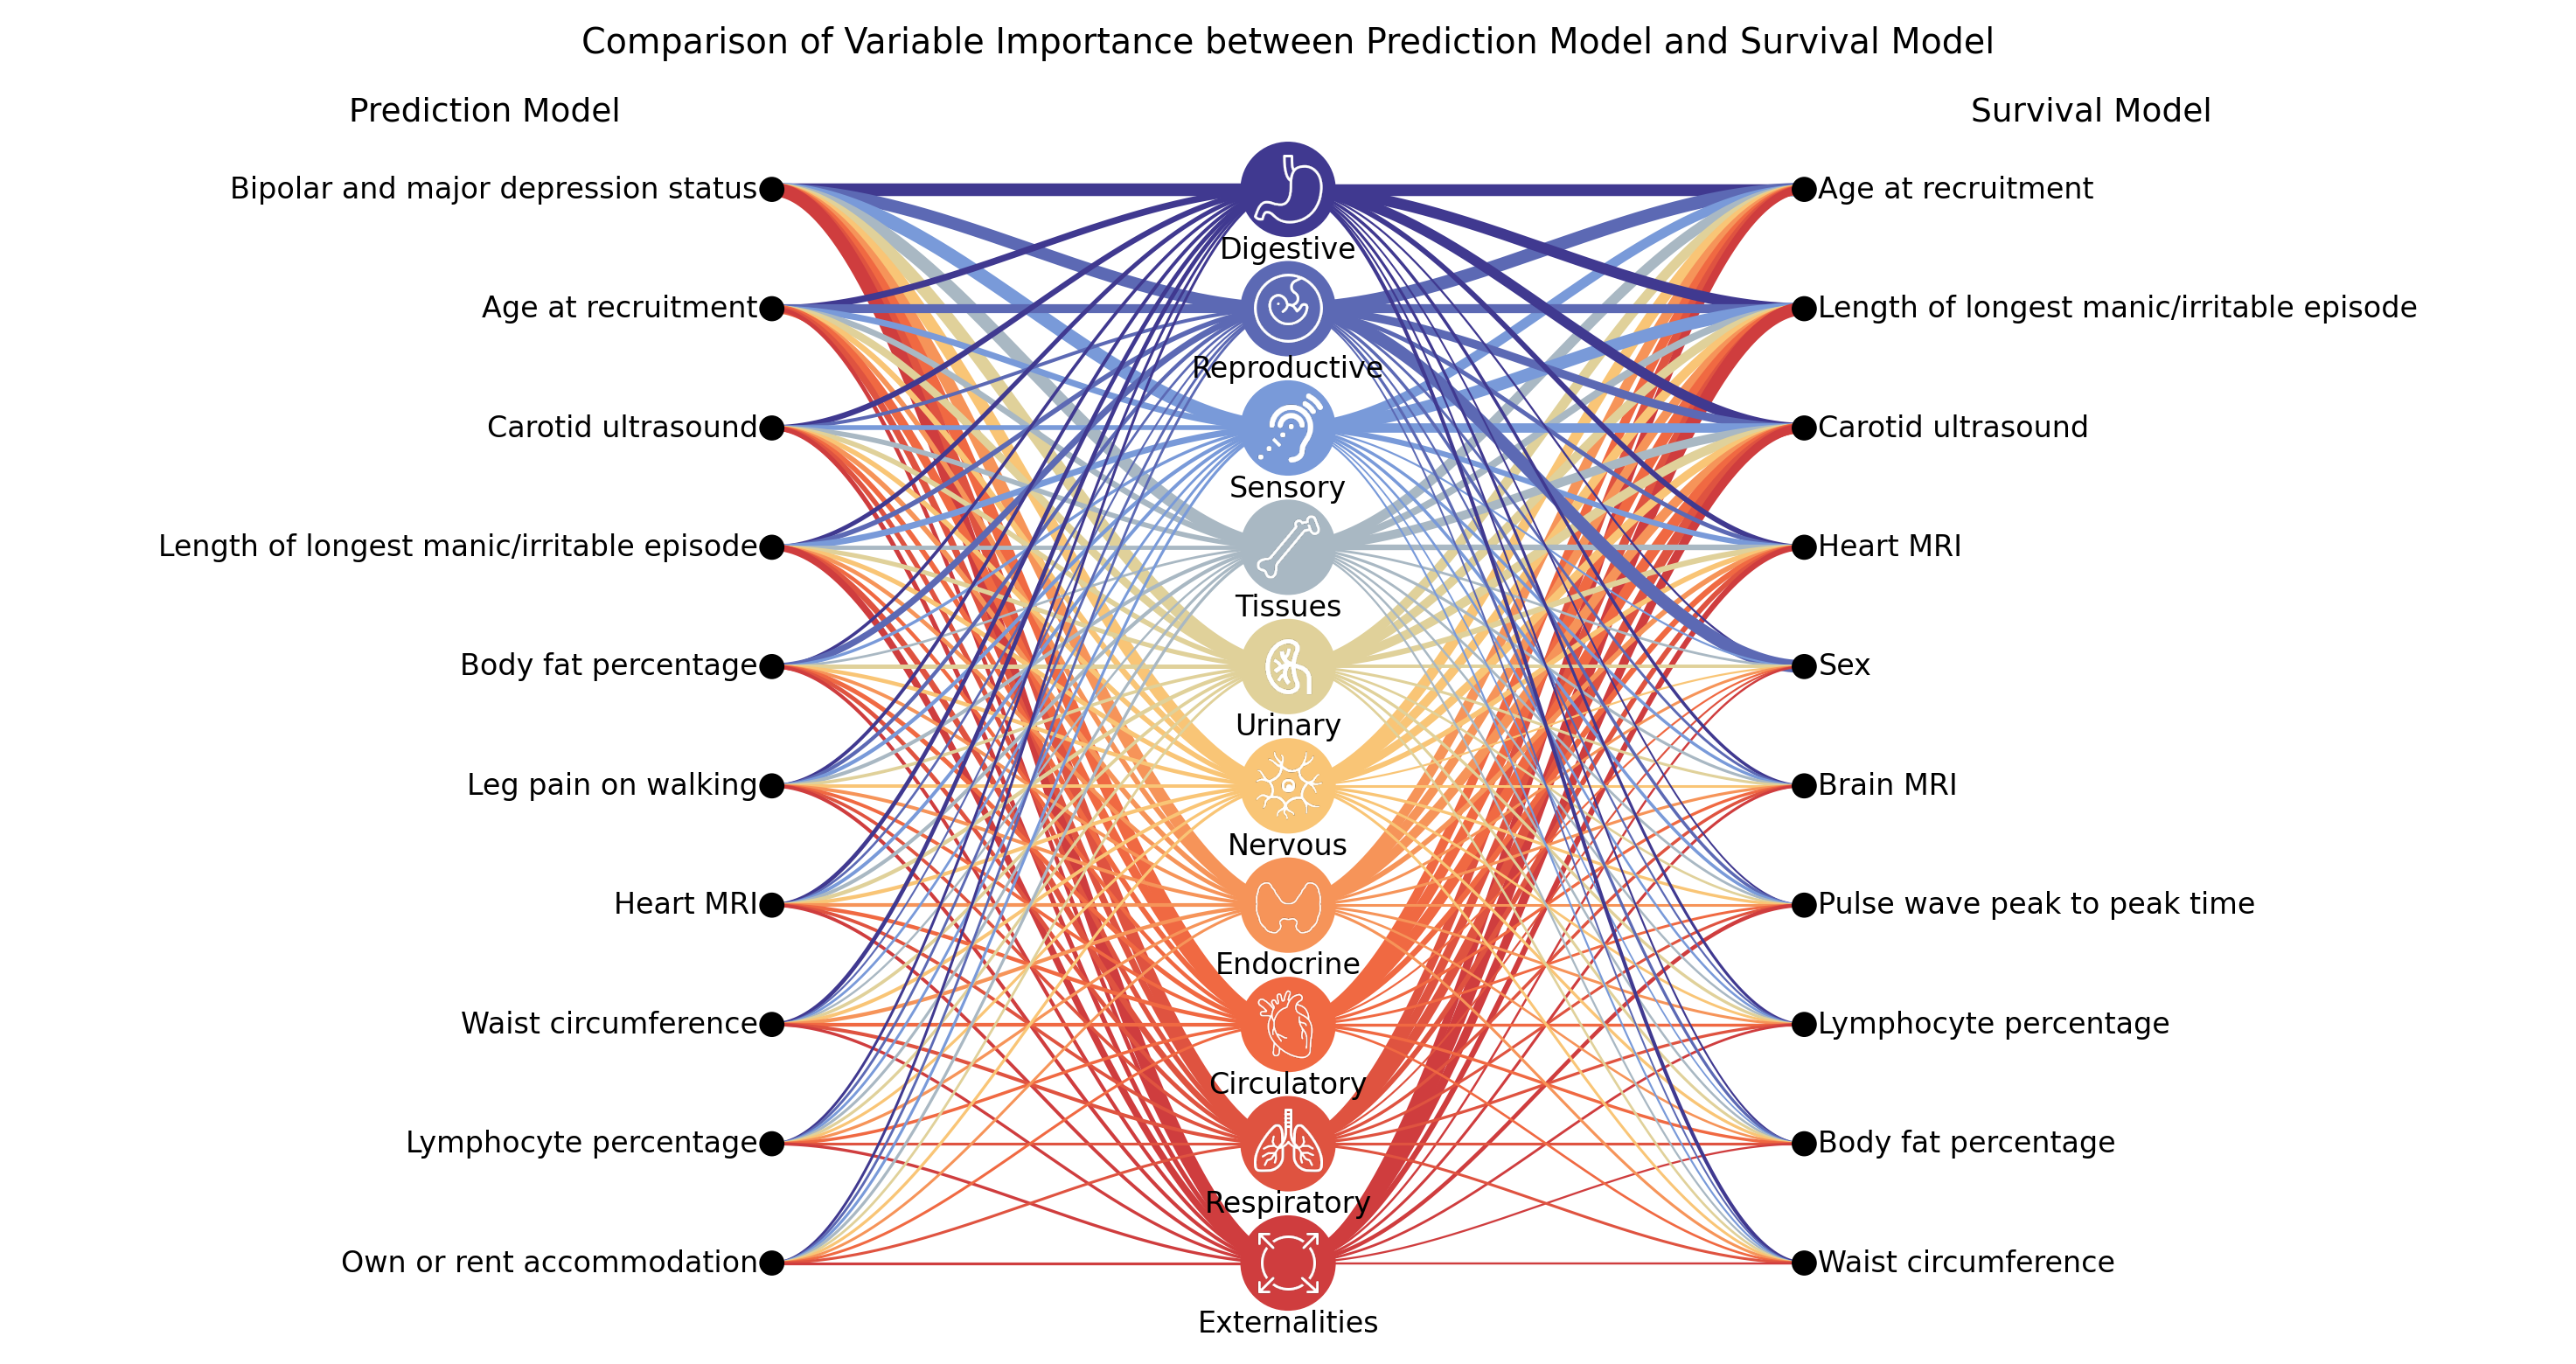

In [20]:
height = 5
width = 11
max_length = 50
x_distance = 4.5
lwidth = 80
random.seed(0)
rancolor = list(range(27))
random.shuffle(rancolor)
catdots=-np.array(0.35+0.52*np.array(range(10)))*2 + 5.7
plt.figure(figsize=(10, 8),dpi=300)
ax = plt.gca()
# draw feature circles, feature text, lines
feature_left = shuffled_df.shape[0]
sys_num = shuffled_df.shape[1]
feature_right = shuffled_dfds.shape[0]
feature_num = feature_left + feature_right
xlocs = np.repeat([1], feature_num).astype(float)
xlocs[0:feature_left] = -1
xlocs *= x_distance
ylocs = np.concatenate([np.linspace(catdots[0], catdots[-1], feature_left), np.linspace(catdots[0], catdots[-1], feature_right)])
rs = (catdots[0] - catdots[-1])/100
for i, xloc in enumerate(xlocs):
    circle = plt.Circle((xloc, ylocs[i]), rs, color="black", fill=True)
    ax.add_artist(circle)
    if xloc < 0:
        info = shuffled_df.iloc[i,:].to_numpy()
        plt.text(xloc-1.3*rs, ylocs[i], auto_wrap(shuffled_df.index[i], max_length), 
                 fontsize=8, ha="right", va="center", color="black")
    else:
        info = shuffled_dfds.iloc[(i-feature_left),:].to_numpy()
        plt.text(xloc+1.3*rs, ylocs[i], auto_wrap(shuffled_dfds.index[i-feature_left], max_length), 
                 fontsize=8, ha="left", va="center", color="black")
    for j, catdot in enumerate(catdots):
        x,y = curve(xloc, ylocs[i], 0, catdot)
        ax.plot(x,y,linewidth=np.abs(info[j]*lwidth + 0 * np.power(info[j],1/3))+0.1, color=cm(j), zorder=0)
# draw center circles, center text
for i, yp in enumerate(catdots):
    circle = plt.Circle((0, yp), 0.4, color=cm(i), fill=True)
    ax.add_artist(circle)
    icon = plt.imread(os.path.join(iconpath, "{}.png".format(catnames[i])))
    ax.imshow(icon, extent=[-0.3,0.3,yp-0.3,yp+0.3], zorder=1)
    plt.text(0, yp-0.4, catnames[i], 
                 fontsize=8, ha="center", va="top", color="black")
ax.set_xlim(-width, width)
ax.set_ylim(-height, height+1)
ax.set_aspect('equal', adjustable='box')
plt.text(-7, 5.6, "Prediction Model", ha='center', fontweight=500, fontsize=9)
plt.text(7, 5.6, "Survival Model", ha='center', fontweight=500, fontsize=9)
plt.title("Comparison of Variable Importance between Prediction Model and Survival Model", loc='center', fontsize=9.5, y=1)
ax.axis('off')
plt.tight_layout()
# output
plt.savefig(temppath + "Curveplot.pdf",format='pdf',bbox_inches="tight")
plt.show()